# Import Library: 분석에 사용할 모듈 설치
**1. Import Library**

In [2]:
!python -m pip install --user --upgrade pip
!pip install pandas-datareader
!pip install tqdm
!pip install missingno
!pip install xgboost
!pip install lightgbm
!pip install pyramid-arima

Requirement already up-to-date: pip in c:\users\kk\appdata\roaming\python\python37\site-packages (19.0.3)
  Using cached https://files.pythonhosted.org/packages/cc/5c/ea5b6dcfd0f55c5fb1e37fb45335ec01cceca199b8a79339137f5ed269e0/pandas_datareader-0.7.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/57/eb/9d7d55ceec57e0e374e70e9ad8d16795ba91960a3c987f3b5ee71d3e8e4d/missingno-0.4.1-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/51/c1/198915b13e98b62a98f48309c41012638464651da755d941f4abe384c012/xgboost-0.82-py2.py3-none-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/00/37/a392e669a83fef72b916009c438a924d2a9d70bc8aea62662b207105ed98/lightgbm-2.2.3-py2.py3-none-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/67/a5/7067ba4029e0caae394f2212aaa4308861330d4bd2ca083f8613737ba2ba/pyramid-arima-0.8.1.tar.gz
  Complete output from command C:\ProgramData\Anaconda3\python.exe -u -c "import setuptools, toke

  Failed building wheel for pyramid-arima
Command "C:\ProgramData\Anaconda3\python.exe -u -c "import setuptools, tokenize;__file__='C:\\Users\\KK\\AppData\\Local\\Temp\\pip-install-4qwct7dv\\pyramid-arima\\setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" install --record C:\Users\KK\AppData\Local\Temp\pip-record-lnlu732c\install-record.txt --single-version-externally-managed --compile" failed with error code 1 in C:\Users\KK\AppData\Local\Temp\pip-install-4qwct7dv\pyramid-arima\


In [3]:
# Auto reload
%reload_ext autoreload
%autoreload 2
from module import *

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


ModuleNotFoundError: No module named 'pyramid'

# Agile분석 결과확인

Train_size: (13128, 29) Test_size: (4416, 29)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)
Number_of_Total_X:  24
Number_of_Selected_X:  12


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


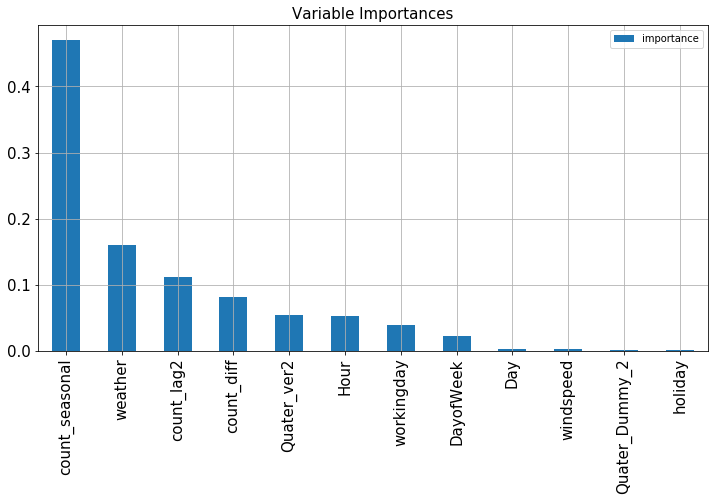

,MAE,MSE,MAPE
Train,6.54,123.38,9.11
Test,51.52,"6,749.92",40.49


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,Stationarity,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-16.29,0.83,986.72,"1,017.92","1,064.70","1,511.67",3.04
p-value,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Alternative,nan,nan,nan,nan,nan,nan,two-sided
Used Lag,27.00,nan,nan,nan,nan,nan,NaN
Used Observations,"13,100.00",nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.43,nan,nan,nan,nan,nan,NaN
Critical Value(5%),nan,nan,nan,nan,nan,nan,NaN
Critical Value(10%),nan,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"98,935.70",nan,nan,nan,nan,nan,NaN


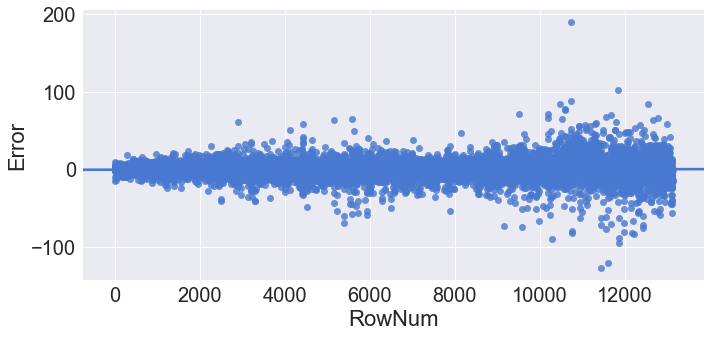

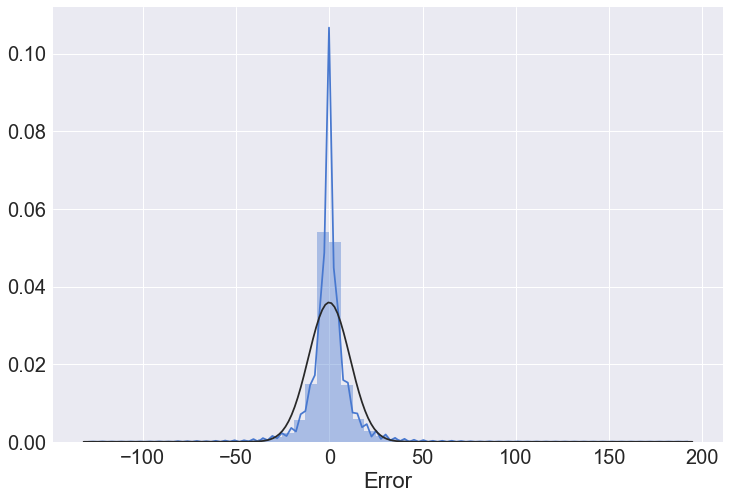

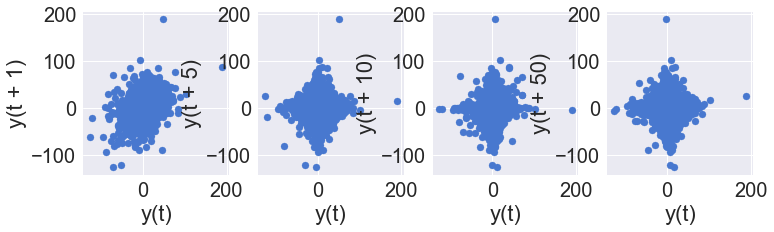

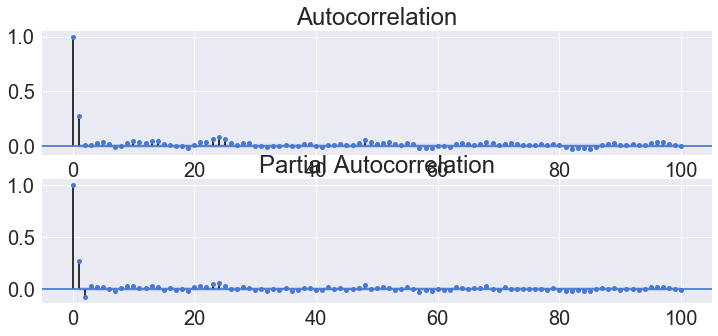

In [6]:
# Data Loading
# location = 'https://raw.githubusercontent.com/cheonbi/DataScience/master/Data/Bike_Sharing_Demand_Full.csv'
location = '../Data/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)

# Feature Engineering
raw_fe = feature_engineering(raw_all)
### Reality ###
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
raw_feR = feature_engineering_year_duplicated(raw_fe, target)
###############

# Data Split
# Confirm of input and output
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_fe.columns if x not in Y_colname+X_remove]
X_train_feR, X_test_feR, Y_train_feR, Y_test_feR = datasplit_ts(raw_feR, Y_colname, X_colname, '2012-07-01')
### Reality ###
target = ['count_lag1', 'count_lag2']
X_test_feR = feature_engineering_lag_modified(Y_test_feR, X_test_feR, target)
###############
### Scaling ###
X_train_feRS, X_test_feRS = feature_engineering_scaling(preprocessing.Normalizer(), X_train_feR, X_test_feR)
###############
### Multicollinearity ###
print('Number_of_Total_X: ', len(X_train_feRS.columns))
X_colname_vif = feature_engineering_XbyVIF(X_train_feRS, 12)
print('Number_of_Selected_X: ', len(X_colname_vif))
X_train_feRSM, X_test_feRSM = X_train_feRS[X_colname_vif].copy(), X_test_feRS[X_colname_vif].copy()
#########################

# Applying Agile Model
# RandomForestRegressor
fit_reg6 = RandomForestRegressor(n_estimators=100, random_state=123).fit(X_train_feRSM, Y_train_feR)
pred_tr_reg6_feRSM = fit_reg6.predict(X_train_feRSM)
pred_te_reg6_feRSM = fit_reg6.predict(X_test_feRSM)

# Prediction Effect of Variables
Variable_Importances = pd.DataFrame([fit_reg6.feature_importances_], 
                                    columns=X_train_feRSM.columns, 
                                    index=['importance']).T.sort_values(by=['importance'], ascending=False)
Variable_Importances.plot.bar(figsize=(12,6), fontsize=15)
plt.title('Variable Importances', fontsize=15)
plt.grid()
plt.show()

# Evaluation
Score_reg6_feRSM, Resid_tr_reg6_feRSM, Resid_te_reg6_feRSM = evaluation_trte(Y_train_feR, pred_tr_reg6_feRSM,
                                                                   Y_test_feR, pred_te_reg6_feRSM, graph_on=False)
display(Score_reg6_feRSM)

# Error Analysis
error_analysis(Resid_tr_reg6_feRSM, ['Error'], X_train_feRSM, graph_on=True)

# Applying Time Series Model: Y예측을 위한 TS분석 실행

Test Statistics         -6.84
p-value                  0.00
Used Lag                41.00
Used Observations   13,086.00
dtype: float64

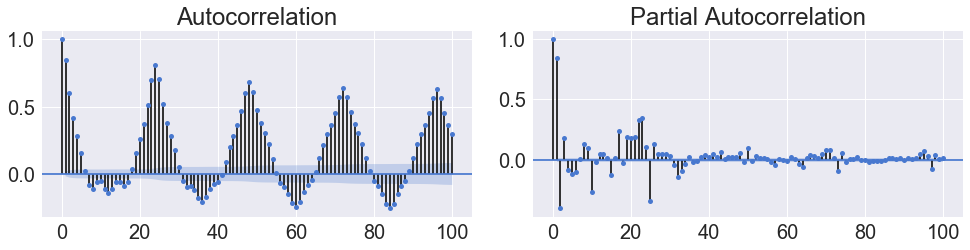

In [7]:
## 정상성 테스트 및 모수추론(p=1, q=1, d=0, P=1, Q=1, D(m)=12)
result = pd.Series(sm.tsa.stattools.adfuller(Y_train_feR.values.flatten())[0:4],
                   index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
display(result)

plt.figure(figsize=(14,4))
sm.tsa.graphics.plot_acf(Y_train_feR, lags=100, alpha=0.05, use_vlines=True, ax=plt.subplot(121))
sm.tsa.graphics.plot_pacf(Y_train_feR, lags=100, alpha=0.05, use_vlines=True, ax=plt.subplot(122))
plt.tight_layout()
plt.show()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              count   No. Observations:                13128
Model:             SARIMAX(1, 0, 0)x(1, 0, 1, 12)   Log Likelihood              -73905.064
Date:                            Sun, 07 Apr 2019   AIC                         147820.128
Time:                                    22:57:35   BIC                         147857.540
Sample:                                01-01-2011   HQIC                        147832.622
                                     - 06-30-2012                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     58.2022      2.610     22.302      0.000      53.087      63.317
ar.L1          0.8248      0.004    187.259      0.000       0.816       0.833
ar.S.L12      -0.9998      0.000  -5396.831      0.000      -1.000      -0.999
ma.S.L12       0.9809      0.002    637.224      0.000       0.978       0.984
sigma2      4529.9751     44.224    102.432      0.000    4443.297    4616.653
===================================================================================
Ljung-Box (Q):                    14342.83   Jarque-Bera (JB):              5597.29
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.58   Skew:                             0.63
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

,MAE,MSE,MAPE
Train,47.80,"4,534.02",126.01
Test,126.11,"31,707.19",140.88


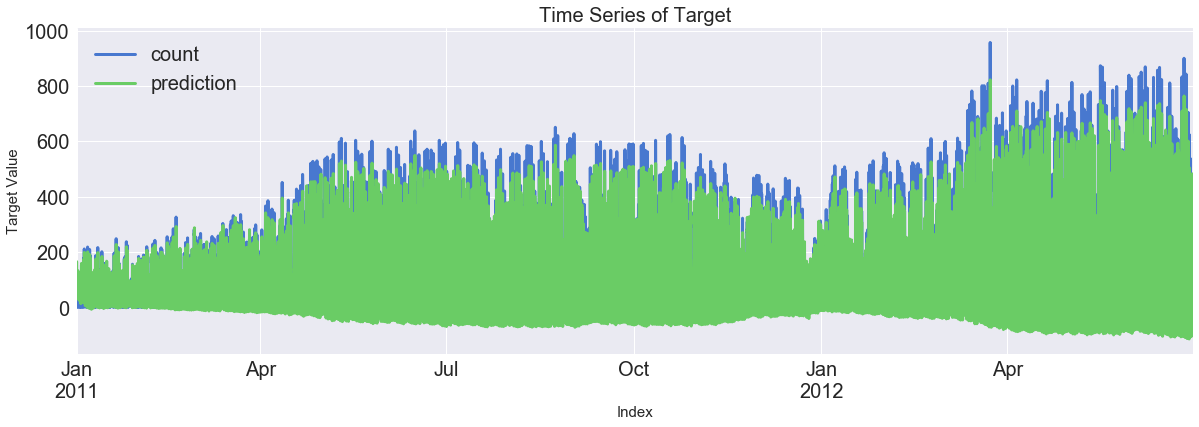

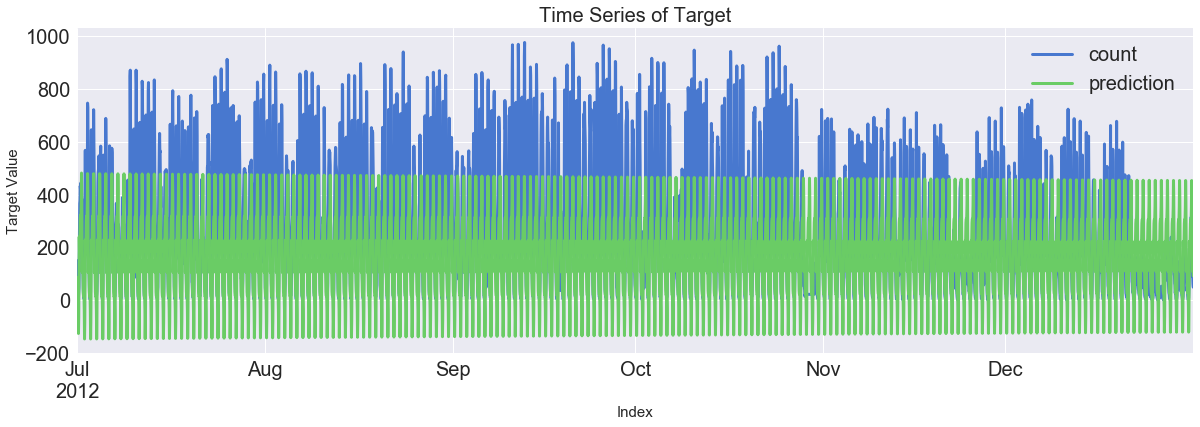

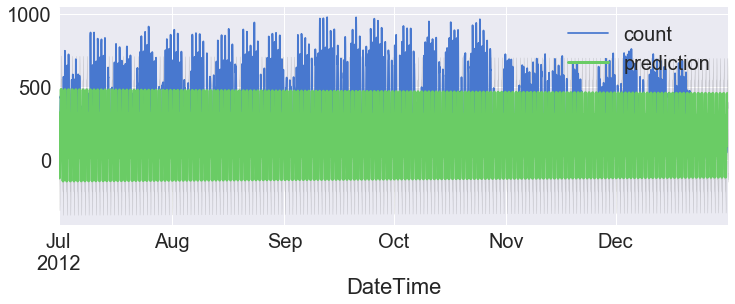

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,Stationarity,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-7.68,0.95,"1,105.78","1,630.45","3,733.66","15,200.47",1.63
p-value,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Alternative,nan,nan,nan,nan,nan,nan,two-sided
Used Lag,41.00,nan,nan,nan,nan,nan,NaN
Used Observations,"13,086.00",nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.43,nan,nan,nan,nan,nan,NaN
Critical Value(5%),nan,nan,nan,nan,nan,nan,NaN
Critical Value(10%),nan,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"139,428.43",nan,nan,nan,nan,nan,NaN


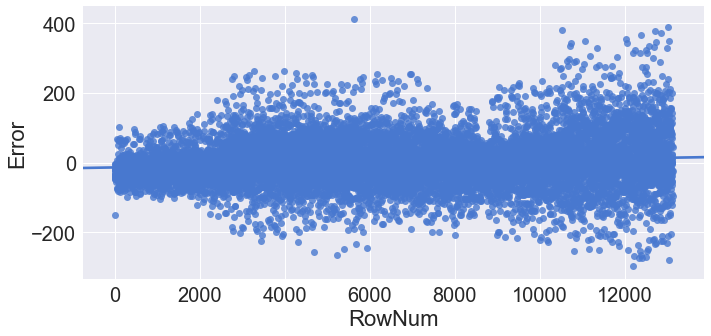

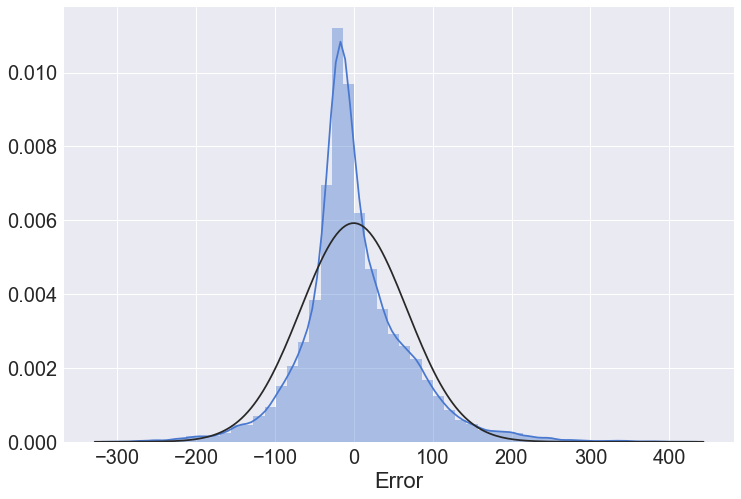

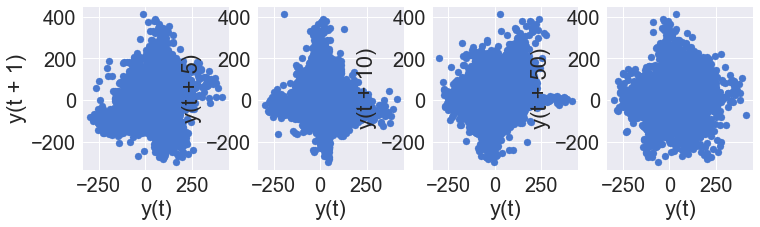

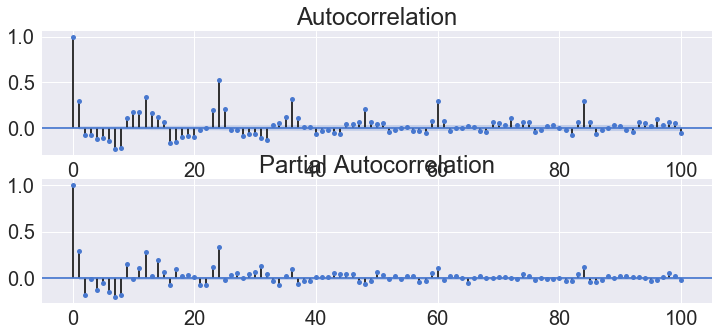

In [8]:
# 모델링
## SARIMA
logarithm, differencing = False, False
trend_diff_order, seasonal_diff_order = 0, 12
fit_ts_sarimax = sm.tsa.SARIMAX(Y_train_feR, order=(1,trend_diff_order,0), 
                                seasonal_order=(1,0,1,seasonal_diff_order), trend='c').fit()
display(fit_ts_sarimax.summary())
pred_tr_ts_sarimax = fit_ts_sarimax.predict()
pred_te_ts_sarimax = fit_ts_sarimax.get_forecast(len(Y_test_feR)).predicted_mean
pred_te_ts_sarimax_ci = fit_ts_sarimax.get_forecast(len(Y_test_feR)).conf_int()
## 비정상성으로 변환
if logarithm:
    Y_train = np.exp(Y_train_feR).copy()
    Y_test = np.exp(Y_test_feR).copy()
    pred_tr_ts_sarimax = np.exp(pred_tr_ts_sarimax).copy()
    pred_te_ts_sarimax = np.exp(pred_te_ts_sarimax).copy()
    pred_te_ts_sarimax_ci = np.exp(pred_te_ts_sarimax_ci).copy()
if differencing:
    pred_tr_ts_sarimax = np.cumsum(pred_tr_ts_sarimax).copy()
    
# 검증
Score_ts_sarimax, Resid_tr_ts_sarimax, Resid_te_ts_sarimax = evaluation_trte(Y_train_feR, pred_tr_ts_sarimax, 
                                                                             Y_test_feR, pred_te_ts_sarimax, graph_on=True)
display(Score_ts_sarimax)
ax = pd.DataFrame(Y_test_feR).plot(figsize=(12,4))
pd.DataFrame(pred_te_ts_sarimax, index=Y_test_feR.index, columns=['prediction']).plot(kind='line',
                                                                           xlim=(Y_test_feR.index.min(),Y_test_feR.index.max()),
                                                                           linewidth=3, fontsize=20, ax=ax)
ax.fill_between(pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).index,
                pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).iloc[:,0],
                pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).iloc[:,1], color='k', alpha=0.15)
plt.show()

# 잔차진단
error_analysis(Resid_tr_ts_sarimax, ['Error'], Y_train_feR, graph_on=True)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              count   No. Observations:                13128
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood              -72713.845
Date:                            Sun, 07 Apr 2019   AIC                         145455.690
Time:                                    23:10:10   BIC                         145560.445
Sample:                                01-01-2011   HQIC                        145490.675
                                     - 06-30-2012                                         
Covariance Type:                              opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          0.0014      0.009      0.148      0.882      -0.017       0.019
count_seasonal  1214.1054     22.870     53.086      0.000    1169.280    1258.931
weather        -1.678e+04   2568.090     -6.535      0.000   -2.18e+04   -1.17e+04
count_lag2      1110.7640     17.100     64.958      0.000    1077.249    1144.279
count_diff      1347.5038     15.408     87.454      0.000    1317.305    1377.703
Quater_ver2     3.292e+04     32.694   1006.911      0.000    3.29e+04     3.3e+04
Hour           -3279.2694    432.414     -7.584      0.000   -4126.785   -2431.754
workingday      7.489e+04    222.257    336.946      0.000    7.45e+04    7.53e+04
DayofWeek       1.594e+04   1304.529     12.217      0.000    1.34e+04    1.85e+04
ar.L1              0.2713      0.013     21.674      0.000       0.247       0.296
ma.L1              0.5726      0.011     51.907      0.000       0.551       0.594
ar.S.L12           0.9998      0.000   5466.005      0.000       0.999       1.000
ma.S.L12          -0.9816      0.001   -666.789      0.000      -0.984      -0.979
sigma2          4135.9212     46.657     88.646      0.000    4044.476    4227.366
===================================================================================
Ljung-Box (Q):                     7183.19   Jarque-Bera (JB):             13133.30
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.46   Skew:                             0.53
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.4e+20. Standard errors may be unstable.
"""

,MAE,MSE,MAPE
Train,42.71,"3,764.76",118.40
Test,107.95,"19,514.89",208.16


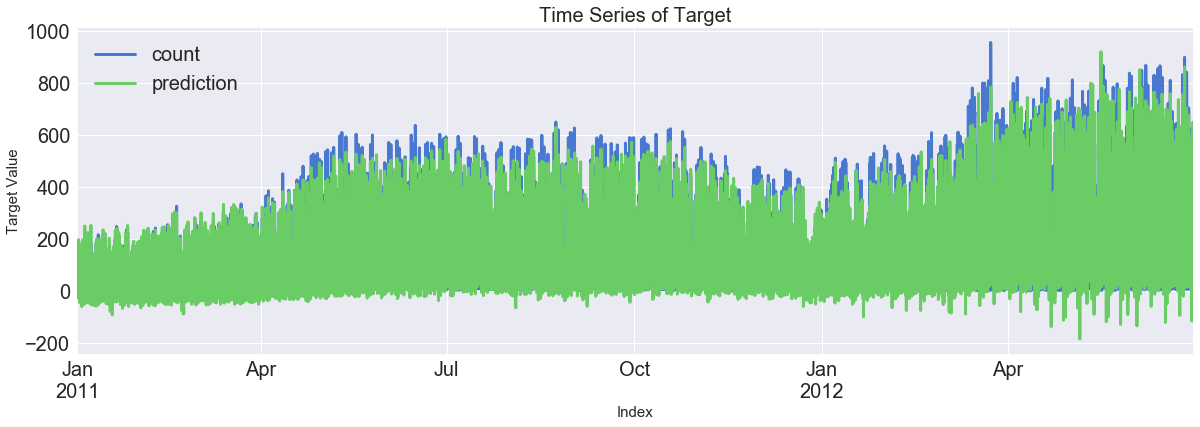

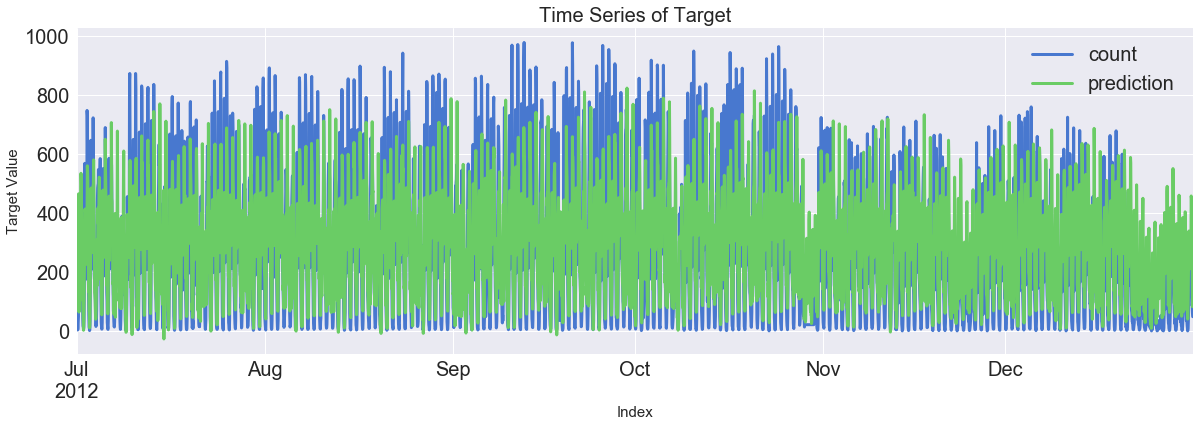

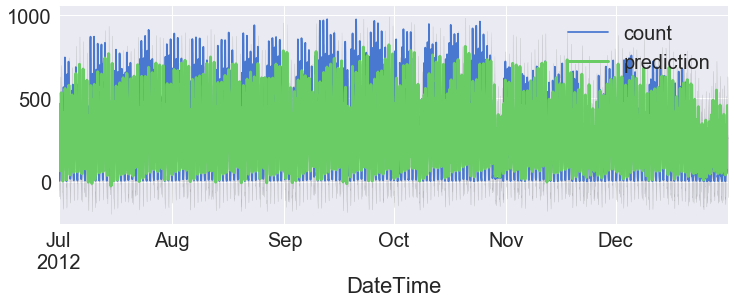

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,Stationarity,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-14.24,0.94,11.59,332.67,"1,942.69","7,659.43",2.29
p-value,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Alternative,nan,nan,nan,nan,nan,nan,two-sided
Used Lag,41.00,nan,nan,nan,nan,nan,NaN
Used Observations,"13,086.00",nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.43,nan,nan,nan,nan,nan,NaN
Critical Value(5%),nan,nan,nan,nan,nan,nan,NaN
Critical Value(10%),nan,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"140,179.40",nan,nan,nan,nan,nan,NaN


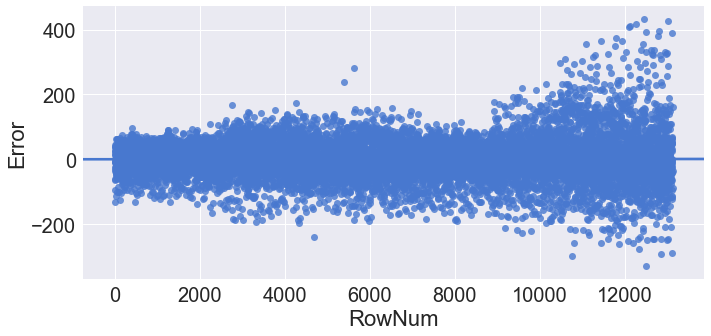

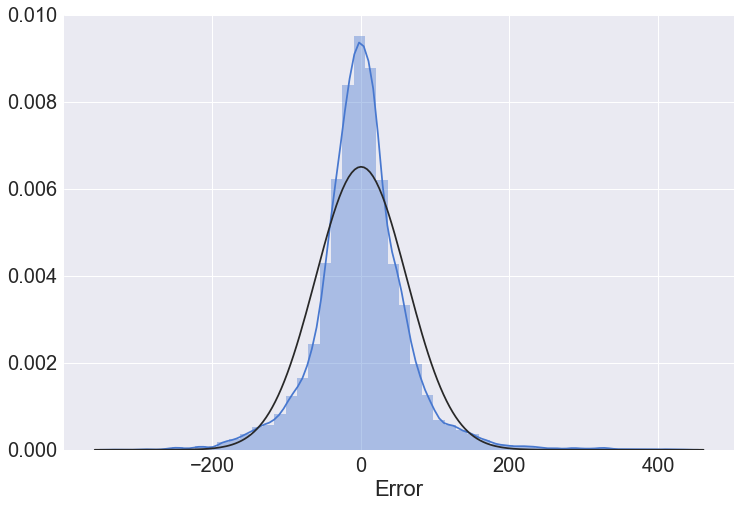

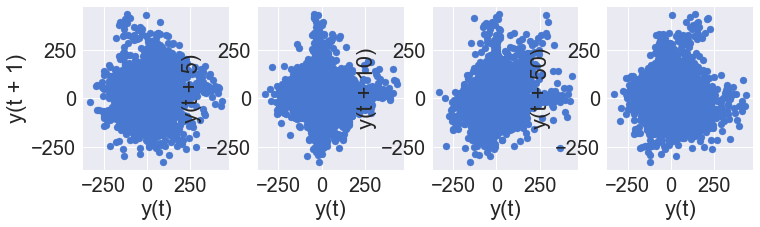

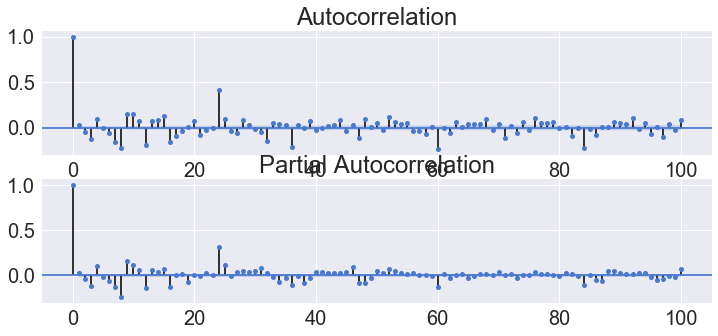

In [14]:
# 모델링
## SARIMAX
logarithm, differencing = False, False
trend_diff_order, seasonal_diff_order = 0, 12
exog_tr = X_train_feRSM[['count_seasonal', 'weather', 'count_lag2', 'count_diff', 'Quater_ver2', 'Hour', 'workingday', 'DayofWeek']]
exog_te = X_test_feRSM[['count_seasonal', 'weather', 'count_lag2', 'count_diff', 'Quater_ver2', 'Hour', 'workingday', 'DayofWeek']]                             
fit_ts_sarimax = sm.tsa.SARIMAX(Y_train_feR, exog=exog_tr, order=(1,trend_diff_order,1), 
                                seasonal_order=(1,0,1,seasonal_diff_order), trend='c').fit()
display(fit_ts_sarimax.summary())
pred_tr_ts_sarimax = fit_ts_sarimax.predict()
pred_te_ts_sarimax = fit_ts_sarimax.get_forecast(len(Y_test_feR), exog=exog_te).predicted_mean
pred_te_ts_sarimax_ci = fit_ts_sarimax.get_forecast(len(Y_test_feR), exog=exog_te).conf_int()
## 비정상성으로 변환
if logarithm:
    Y_train = np.exp(Y_train_feR).copy()
    Y_test = np.exp(Y_test_feR).copy()
    pred_tr_ts_sarimax = np.exp(pred_tr_ts_sarimax).copy()
    pred_te_ts_sarimax = np.exp(pred_te_ts_sarimax).copy()
    pred_te_ts_sarimax_ci = np.exp(pred_te_ts_sarimax_ci).copy()
if differencing:
    pred_tr_ts_sarimax = np.cumsum(pred_tr_ts_sarimax).copy()
    
# 검증
Score_ts_sarimax, Resid_tr_ts_sarimax, Resid_te_ts_sarimax = evaluation_trte(Y_train_feR, pred_tr_ts_sarimax, 
                                                                             Y_test_feR, pred_te_ts_sarimax, graph_on=True)
display(Score_ts_sarimax)
ax = pd.DataFrame(Y_test_feR).plot(figsize=(12,4))
pd.DataFrame(pred_te_ts_sarimax, index=Y_test_feR.index, columns=['prediction']).plot(kind='line',
                                                                           xlim=(Y_test_feR.index.min(),Y_test_feR.index.max()),
                                                                           linewidth=3, fontsize=20, ax=ax)
ax.fill_between(pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).index,
                pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).iloc[:,0],
                pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).iloc[:,1], color='k', alpha=0.15)
plt.show()

# 잔차진단
error_analysis(Resid_tr_ts_sarimax, ['Error'], Y_train_feR, graph_on=True)

In [10]:
# 모델링
## Auto-ARIMA
logarithm, differencing = False, False
trend_diff_order, seasonal_diff_order = 0, 12
exog_tr = X_train_feRSM[['count_seasonal', 'weather', 'count_lag2', 'count_diff', 'Quater_ver2', 'Hour', 'workingday', 'DayofWeek']]
exog_te = X_test_feRSM[['count_seasonal', 'weather', 'count_lag2', 'count_diff', 'Quater_ver2', 'Hour', 'workingday', 'DayofWeek']]                             
fit_ts_autoarima = auto_arima(Y_train_feR, exogenous=exog_tr, stationary=False,
                              trend='c', start_p=0, start_q=0, max_p=2, max_q=2, max_d=1,
                              seasonal=True, start_P=0, start_Q=0, max_P=1, max_Q=1, m=seasonal_diff_order,
                              stepwise=True, trace=True)
display(fit_ts_autoarima.summary())
pred_tr_ts_autoarima = fit_ts_autoarima.predict_in_sample(exogenous=exog_tr)
pred_te_ts_autoarima = fit_ts_autoarima.predict(len(Y_test_feR), exogenous=exog_te, return_conf_int=True)[0]
pred_te_ts_autoarima_ci = fit_ts_autoarima.predict(len(Y_test_feR), exogenous=exog_te, return_conf_int=True)[1]
## 비정상성으로 변환
if logarithm:
    Y_train = np.exp(Y_train).copy()
    Y_test = np.exp(Y_test).copy()
    pred_tr_ts_autoarima = np.exp(pred_tr_ts_autoarima).copy()
    pred_te_ts_autoarima = np.exp(pred_te_ts_autoarima).copy()
    pred_te_ts_autoarima_ci = np.exp(pred_te_ts_autoarima_ci).copy()
if differencing:
    pred_tr_ts_autoarima = np.cumsum(pred_tr_ts_autoarima).copy()
    
# 검증
Score_ts_autoarima, Resid_tr_ts_autoarima, Resid_te_ts_autoarima = evaluation_trte(Y_train_feR, pred_tr_ts_autoarima, 
                                                                             Y_test_feR, pred_te_ts_autoarima, graph_on=True)
display(Score_ts_autoarima)
ax = pd.DataFrame(Y_test_feR).plot(figsize=(12,4))
pd.DataFrame(pred_te_ts_autoarima, index=Y_test_feR.index, columns=['prediction']).plot(kind='line',
                                                                           xlim=(Y_test_feR.index.min(),Y_test_feR.index.max()),
                                                                           linewidth=3, fontsize=20, ax=ax)
ax.fill_between(pd.DataFrame(pred_te_ts_autoarima_ci, index=Y_test_feR.index).index,
                pd.DataFrame(pred_te_ts_autoarima_ci, index=Y_test_feR.index).iloc[:,0],
                pd.DataFrame(pred_te_ts_autoarima_ci, index=Y_test_feR.index).iloc[:,1], color='k', alpha=0.15)
plt.show()

# 잔차진단
error_analysis(Resid_tr_ts_autoarima, ['Error'], Y_train_feR, graph_on=True)


Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=160516.375, BIC=160598.673, Fit time=19.777 seconds


KeyboardInterrupt: 